In [1]:
import torch as t
from torch import nn
from torch.autograd import Variable as V

* nn.linear的输入为(N,input_features),输出为(N,out_features),N是batch_size，输入的是一个batch，而不是一个数据，如果要输入一个数据，必须调用unsqeeze(0)函数将数据伪装为batch_size = 1。

In [7]:
class Linear(nn.Module):
    def __init__(self,in_features,out_features):
        super(Linear,self).__init__()# 等价于 nn.Module.__init__(self)
        self.w = nn.Parameter(t.randn(in_features,out_features))
        self.b = nn.Parameter(t.randn(out_features))
        
    def forward(self,x):
        x = x.mm(self.w)
        return x + self.b.expand_as(x)

In [11]:
layer = Linear(4,3)
input = V(t.randn(2,4))
output = layer(input)
output

tensor([[-0.9253, -0.8976, -0.2209],
        [-1.1664,  1.9973, -1.3672]], grad_fn=<AddBackward0>)

In [12]:
for name,parameter in layer.named_parameters():
    print(name,parameter)

w Parameter containing:
tensor([[-0.1528, -1.3926,  1.0754],
        [ 0.2503,  0.3859, -0.3433],
        [-0.6489,  0.3708,  1.1377],
        [-0.4434, -0.6026,  1.2142]], requires_grad=True)
b Parameter containing:
tensor([-0.8055,  0.5988, -1.2159], requires_grad=True)


### 多层感知机

In [20]:
class Perceptron(nn.Module):
    def __init__(self,in_features,hidden_features,out_features):
        nn.Module.__init__(self)
        self.layer1 = Linear(in_features,hidden_features)
        self.layer2 = Linear(hidden_features,out_features)
    
    def forward(self,x):
        x = self.layer1(x)
        x = t.sigmoid(x)
        return self.layer2(x)

In [23]:
perceptron = Perceptron(3,4,1)
for name,param in perceptron.named_parameters():
    print(name,param.size())
    print(name,param)

layer1.w torch.Size([3, 4])
layer1.w Parameter containing:
tensor([[-1.1005, -1.0179,  0.6542,  0.0904],
        [-0.0831,  0.0328, -0.9879, -0.7647],
        [ 0.8134,  0.0522, -0.7636,  0.2237]], requires_grad=True)
layer1.b torch.Size([4])
layer1.b Parameter containing:
tensor([-0.7032, -0.1293, -0.2529,  1.1757], requires_grad=True)
layer2.w torch.Size([4, 1])
layer2.w Parameter containing:
tensor([[-2.0297],
        [ 1.1871],
        [ 1.3601],
        [-1.4870]], requires_grad=True)
layer2.b torch.Size([1])
layer2.b Parameter containing:
tensor([0.5728], requires_grad=True)


### 常见的神经网络层

* 图像相关层

主要包括卷积层（前向卷积，逆卷积），池化层（平均池化，最大值池化，自适应池化）

In [29]:
from PIL import Image
from torchvision.transforms import ToTensor,ToPILImage

In [34]:
to_tensor = ToTensor() # img -> tensor
to_pil = ToPILImage()
lena = Image.open('lena.png')

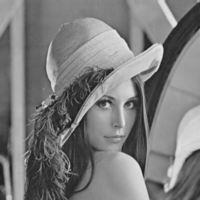

In [35]:
lena

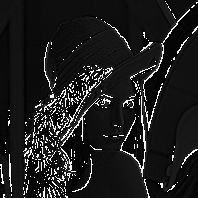

In [37]:
input = to_tensor(lena).unsqueeze(0)

#锐化卷积核
kernal = t.ones(3,3) / -9
kernal[1][1] = 1
conv = nn.Conv2d(1,1,(3,3),1,bias=False)
conv.weight.data = kernal.view(1,1,3,3)

out = conv(V(input))
to_pil(out.data.squeeze(0))

池化层没有可学习的参数，weight是固定的。

In [53]:
pool = nn.AvgPool2d(2,2)
list(pool.parameters())

[]

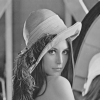

In [55]:
out = pool(V(input))
to_pil(out.data.squeeze(0))

In [56]:
print('池化后的图')

池化后的图


>`Linear`:全连接层 

> `BatchNorm`：批规范化层，分为1D，2D，3D

>  `Dropout`：用来防止过拟合

In [61]:
input = V(t.randn(2,3))
linear = nn.Linear(3,4)
h = linear(input)
h

tensor([[ 0.7608, -0.9684, -1.4210, -1.2307],
        [ 0.0758, -0.1672,  0.8975, -0.2515]], grad_fn=<AddmmBackward>)

In [62]:
# 初始化标准差为4，均值为0
bn = nn.BatchNorm1d(4)
bn.weight.data = t.ones(4) * 4
bn.bias.data = t.zeros(4)

In [64]:
bn.weight.data

tensor([4., 4., 4., 4.])

In [70]:
bn_out = bn(h)

#计算无偏方差分母会减1，使用unbiased = False，分母不减1
bn_out.mean(0),bn_out.var(0,unbiased = False)

(tensor([ 0.0000e+00, -1.1921e-07,  0.0000e+00, -1.1921e-07],
        grad_fn=<MeanBackward1>),
 tensor([15.9986, 15.9990, 15.9999, 15.9993], grad_fn=<VarBackward1>))

In [71]:
# 每个元素以0.5的概率舍弃
dropout = nn.Dropout(0.5)
o = dropout(bn_out)
o

tensor([[ 0.0000, -7.9998, -8.0000, -7.9998],
        [-0.0000,  7.9998,  0.0000,  0.0000]], grad_fn=<MulBackward0>)

### 激活函数

`ReLu(x) = max(0,x)`

In [76]:
relu = nn.ReLU(inplace=True)# inplace如果是True，把输出直接覆盖到输入中
input = V(t.randn(2,3))
print(input)

tensor([[ 0.4020, -1.8636,  2.2076],
        [ 0.7721,  0.0805,  0.1260]])


In [77]:
output = relu(input)
output# 小于0的都被截断为0

tensor([[0.4020, 0.0000, 2.2076],
        [0.7721, 0.0805, 0.1260]])

In [78]:
# Sequential的三种写法
net1 = nn.Sequential()
net1.add_module('conv',nn.Conv2d(3,3,3))
net1.add_module('batchnorm',nn.BatchNorm2d(3))
net1.add_module('activation_layer',nn.ReLU())

net2 = nn.Sequential(
        nn.Conv2d(3,3,3),
        nn.BatchNorm2d(3),
        nn.ReLU()
        )

In [82]:
from collections import OrderedDict
net3 = nn.Sequential(OrderedDict([
        ('conv1',nn.Conv2d(3,3,3)),
        ('bn1',nn.BatchNorm2d(3)),
        ('relu1',nn.ReLU())
]))

print('net1:',net1)
print('----------------------------------------------------')
print('net2:',net2)
print('----------------------------------------------------')
print('net3:',net3)

net1: Sequential(
  (conv): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_layer): ReLU()
)
----------------------------------------------------
net2: Sequential(
  (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)
----------------------------------------------------
net3: Sequential(
  (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
)


In [84]:
input = V(t.rand(1,3,4,4))
output = net1(input)
output = net2(input)
output = net3(input)

output = net3.relu1(net1.batchnorm(net1.conv(input)))

modellist = nn.ModuleList([nn.Linear(3,4),nn.ReLU(),nn.Linear(4,2)])
input = V(t.randn(1,3))

for model in modellist:
    input = model(input)
    print(input)

tensor([[-0.7562, -0.2304,  0.0222, -0.2569]], grad_fn=<AddmmBackward>)
tensor([[0.0000, 0.0000, 0.0222, 0.0000]], grad_fn=<ReluBackward0>)
tensor([[-0.1930,  0.2603]], grad_fn=<AddmmBackward>)


In [85]:
class MyModule(nn.Module):
    def __init__(self):
        super(MyModule,self).__init__()
        self.list = [nn.Linear(3,4),nn.ReLU()]
        self.module_list = nn.ModuleList([nn.Conv2d(3,3,3),nn.ReLU()])
        
    def forward(self):
        pass
    
model = MyModule()
model

MyModule(
  (module_list): ModuleList(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
)

In [86]:
for name, param in model.named_parameters():
    print(name,param.size())

module_list.0.weight torch.Size([3, 3, 3, 3])
module_list.0.bias torch.Size([3])


### 循环神经网络层

RNN和RNNCell层的区别在于前者能够处理整个序列，后者一次只处理序列中一个时间点的数据。

In [87]:
t.manual_seed(1000)
input = V(t.randn(2,3,4))#batch_size=3，序列长度为2，序列中每个元素占4维

lstm = nn.LSTM(4,3,1)# 4维，3个隐藏元，1层

h0 = V(t.randn(1,3,3)) # 1层，batch_size=3,3个隐藏元
c0 = V(t.randn(1,3,3))
out,hn = lstm(input,(h0,c0))
out

tensor([[[-0.3610, -0.1643,  0.1631],
         [-0.0613, -0.4937, -0.1642],
         [ 0.5080, -0.4175,  0.2502]],

        [[-0.0703, -0.0393, -0.0429],
         [ 0.2085, -0.3005, -0.2686],
         [ 0.1482, -0.4728,  0.1425]]], grad_fn=<StackBackward>)

In [88]:
t.manual_seed(1000)
input = V(t.randn(2,3,4))#batch_size=3，序列长度为2，序列中每个元素占4维

lstm = nn.LSTMCell(4,3)# 4维，3个隐藏元，LSTMCell对应的层数只能是1层

hx = V(t.randn(3,3)) # 1层，batch_size=3,3个隐藏元
cx = V(t.randn(3,3))

out = []

for i_ in  input:
    hx,cx = lstm(i_,(hx,cx))
    out.append(hx)
t.stack(out)

tensor([[[-0.3610, -0.1643,  0.1631],
         [-0.0613, -0.4937, -0.1642],
         [ 0.5080, -0.4175,  0.2502]],

        [[-0.0703, -0.0393, -0.0429],
         [ 0.2085, -0.3005, -0.2686],
         [ 0.1482, -0.4728,  0.1425]]], grad_fn=<StackBackward>)

In [92]:
out[0][0][0]

tensor(-0.3610, grad_fn=<SelectBackward>)

In [93]:
# 4个词，每个词用5维向量表示
embedding = nn.Embedding(4,5)
embedding.weight.data = t.arange(0,20).view(4,5)

input = V(t.arange(3,0,-1)).long()

output = embedding(input)
output

tensor([[15, 16, 17, 18, 19],
        [10, 11, 12, 13, 14],
        [ 5,  6,  7,  8,  9]], grad_fn=<EmbeddingBackward>)

### 损失函数

In [106]:
score = V(t.randn(3,2))
label = V(t.Tensor([1,0,1])).long()
criterion = nn.CrossEntropyLoss()# 交叉熵函数
loss = criterion(score,label)
loss

tensor(1.6117)

### 优化器

* 随机梯度下降法（SGD）

In [109]:
# 首先定义一个LeNet网络
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.features = nn.Sequential(
                    nn.Conv2d(3, 6, 5),
                    nn.ReLU(),
                    nn.MaxPool2d(2,2),
                    nn.Conv2d(6, 16, 5),
                    nn.ReLU(),
                    nn.MaxPool2d(2,2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 16 * 5 * 5)
        x = self.classifier(x)
        return x

net = Net()

In [110]:
from torch import optim
optimizer = optim.SGD(params = net.parameters(),lr = 1)
optimizer.zero_grad() #梯度清零

input = V(t.randn(1,3,32,32))
output = net(input)
output.backward(output)

optimizer.step()# 执行优化

In [111]:
# 为不同子网络设置不同的学习率
optimizer = optim.SGD([
        {'params': net.features.parameters()},# 学习率为1e-5
        {'params': net.classifier.parameters(),'lr': 1e-2}
],lr = 1e-5)

In [115]:
special_layers = nn.ModuleList([net.classifier[0],net.classifier[3]])
special_layers_params = list(map(id,special_layers.parameters()))

base_params = filter(lambda p : id(p) not in special_layers_params,net.parameters())

optimizer = t.optim.SGD([
            {'params': base_params},
            {'params': special_layers.parameters(),'lr': 0.01}
],lr = 0.001)

In [118]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 1e-05
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    lr: 0.010000000000000002
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [116]:
# 调整学习率，新建一个optimizer
old_lr = 0.1
optimizer = optim.SGD([
        {'params': net.features.parameters()},
        {'params': net.classifier.parameters(),'lr' : old_lr * 0.1}
],lr = 1e-5)

In [117]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 1e-05
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    lr: 0.010000000000000002
    momentum: 0
    nesterov: False
    weight_decay: 0
)

### nn.functional

In [119]:
input = V(t.randn(2,3))
model = nn.Linear(3,4)
output1 = model(input)
output2 = nn.functional.linear(input,model.weight,model.bias)
output1 == output2

tensor([[True, True, True, True],
        [True, True, True, True]])

In [120]:
b = nn.functional.relu(input)
b2 = nn.ReLU()(input)
b == b2

tensor([[True, True, True],
        [True, True, True]])

如果模型有可学习的参数，用nn.Module，否则都可以使用

In [121]:
from torch.nn import functional as F

In [125]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.conv2 = nn.Conv2d(6,16,5)        
        self.fc1 = nn.Linear(16 * 5 * 5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)        
        
    def forward(self,x):
        x = F.pool(F.relu(self.conv1(x)),2)
        x = F.pool(F.relu(self.conv2(x)),2)        
        
        x = x.view(-1,16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [126]:
class MyLinear(nn.Module):
    def __init__(self):
        super(MyLinear,self).__init__()
        self.weight = nn.Parameter(t.randn(3,4))
        self.bias = nn.Parameter(t.zeros(3))
        
    def forward(self):
        return F.linear(input,weight,bias)


### 初始化策略

In [127]:
# 利用nn.init初始化
from torch.nn import init

In [131]:
linear = nn.Linear(3,4)

t.manual_seed(1)
init.xavier_normal(linear.weight)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  after removing the cwd from sys.path.


Parameter containing:
tensor([[ 0.3535,  0.1427,  0.0330],
        [ 0.3321, -0.2416, -0.0888],
        [-0.8140,  0.2040, -0.5493],
        [-0.3010, -0.4769, -0.0311]], requires_grad=True)

In [132]:
# 直接初始化
import math
t.manual_seed(1)

#xavier初始化的计算公式
std = math.sqrt(2) / math.sqrt(7.)
linear.weight.data.normal_(0,std)

tensor([[ 0.3535,  0.1427,  0.0330],
        [ 0.3321, -0.2416, -0.0888],
        [-0.8140,  0.2040, -0.5493],
        [-0.3010, -0.4769, -0.0311]])

In [133]:
# 对模型的所有参数进行初始化
for name,params in net.named_parameters():
    if name.find('linear') != -1:
        #init linear
        params[0] # weight
        params[1] # bias
    elif name.find('conv') != -1:
        pass
    elif name.find('norm') != -1:
        pass

nn.Module基类的构造函数

```python
def __init__(self):
    self._parameters = OrderedDict() # 字典，保存用户直接设置的parameter
    self._modules = OrderedDict() # 子module
    self._buffers = OrderedDict() # 缓存
    self._backward_hooks = OrderedDict() # 用来提取中间变量
    self._forward_hooks = OrderedDict() 
    self.training = True
```

In [135]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.param1 = nn.Parameter(t.rand(3,3))
        self.submodel1 = nn.Linear(3,4)
        
    def forward(self,input):
        x = self.param1@input
        x = self.submodel1(x)
        return x

In [136]:
net = Net()
net

Net(
  (submodel1): Linear(in_features=3, out_features=4, bias=True)
)

In [137]:
net._modules

OrderedDict([('submodel1', Linear(in_features=3, out_features=4, bias=True))])

In [140]:
net._parameters

OrderedDict([('param1', Parameter containing:
              tensor([[0.3398, 0.5239, 0.7981],
                      [0.7718, 0.0112, 0.8100],
                      [0.6397, 0.9743, 0.8300]], requires_grad=True))])

In [141]:
net._buffers

OrderedDict()

In [142]:
for name,param in net.named_parameters():
    print(name,param.size())

param1 torch.Size([3, 3])
submodel1.weight torch.Size([4, 3])
submodel1.bias torch.Size([4])


In [143]:
for name,submodel in net.named_modules():
    print(name,submodel)

 Net(
  (submodel1): Linear(in_features=3, out_features=4, bias=True)
)
submodel1 Linear(in_features=3, out_features=4, bias=True)


In [144]:
bn = nn.BatchNorm1d(2)
input = V(t.rand(3,2),requires_grad = True)
output = bn(input)
bn._buffers

OrderedDict([('running_mean', tensor([0.0362, 0.0596])),
             ('running_var', tensor([0.9009, 0.9262])),
             ('num_batches_tracked', tensor(1))])

In [152]:
input = V(t.arange(0,12).view(3,4))
model = nn.Dropout()
model(input.float())

tensor([[ 0.,  2.,  4.,  6.],
        [ 0.,  0., 12.,  0.],
        [16., 18.,  0.,  0.]])

In [156]:
model.training = False
model(input)#测试阶段，dropout什么都不做

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])

In [157]:
print(net.training,net.submodel1.training)
net.eval()# eval会将training属性设置为false
net.training,net.submodel1.training

True True


(False, False)

In [158]:
list(net.named_modules())

[('', Net(
    (submodel1): Linear(in_features=3, out_features=4, bias=True)
  )), ('submodel1', Linear(in_features=3, out_features=4, bias=True))]

伪代码
```python
model = VGG()
features = t.Tensor()
def hook(module,inpout,output):
    '''
    把这层的输出复制到features中
    '''
    features.copy_(output.data)
    
handle = model.layer8.register_forward_hook(hook)
_ = model(input)
#用完hook后删除
handle.remove()
```

### ResNet深度残差网络

In [161]:
from torch import nn
import torch as t
from torch.nn import functional as F

In [163]:
class ResidualBlock(nn.Module):
    '''
    实现子module
    '''
    
    def __init__(self,inchannel,outchannel,stride = 1,shortcut = None):
        super(ResidualBlock,self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel,outchannel,3,stride,1,bias = False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel,outchannel,3,1,1,bias=False),
            nn.BatchNorm2d(outchannel))
        self.right = shortcut
        
    def forward(self,x):
        out = self.left(x)
        residual = x if self.right is None else self.right(x)
        out += residual
        return F.relu(out)

In [164]:
class ResNet(nn.Module):
    '''
    实现主Module，ResNet34包含多个layer，每个layer包含多个residual block
    用子module实现residual block，用_make_layer函数实现layer
    '''
    def __init__(self,num_classes = 1000):
        super(ResNet,self).__init__()
        # 前几层图像转换
        self.pre = nn.Sequential(
                nn.Conv2d(3,64,7,2,3,bias = False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(3,2,1))
        
        # 重复的layer，分别为3，4，6，3个residual block
        self.layer1 = self._make_layer(64,128,3)
        self.layer2 = self._make_layer(128,256,4,stride = 2)        
        self.layer3 = self._make_layer(256,512,6,stride = 2)        
        self.layer4 = self._make_layer(512,512,3,stride = 2)        
        
        # 分类用的全连接
        self.fc = nn.Linear(512,num_classes)
        
    def _make_layer(self,inchannel,outchannel,block_num,stride=1):
        '''
        构建layer，包含多个residual block
        '''
        shortcut = nn.Sequential(
                nn.Conv2d(inchannel,outchannel,1,stride,bias=False),
                nn.BatchNorm2d(outchannel))
        
        layers = []
        layers.append(ResidualBlock(inchannel,outchannel,stride,shortcut))
        
        for i in range(1,block_num):
            layers.append(ResidualBlock(outchannel,outchannel))

            return nn.Sequential(*layers)
        
    def forward(self,x):
        x = self.pre(x)
        
        x = self.layer1(x)
        x = self.layer2(x)        
        x = self.layer3(x)        
        x = self.layer4(x)        
        
        x = F.avg_pool2d(x,7)
        x = x.view(x.size(0),-1)
        return self.fc(x)

In [172]:
import numpy as np
model = ResNet()
input = t.autograd.Variable(t.randn(1,3,224,224))
o = model(input)
o

tensor([[ 7.4391e-01,  4.7439e-02,  2.4947e-01, -3.0652e-01,  1.8442e-01,
          1.2756e-01, -5.2462e-01,  5.0733e-01, -1.4874e-01,  4.8849e-01,
          8.4501e-02,  6.6860e-01, -2.0913e-01,  4.7739e-01, -1.4310e-02,
         -2.7774e-01,  3.1799e-01, -4.7529e-01,  8.2248e-01,  1.0754e-01,
         -2.5474e-01,  2.0272e-01,  9.2638e-02,  4.4209e-01,  1.2966e-01,
          2.7396e-01, -1.1623e-01,  4.7106e-01, -9.0877e-01,  8.7586e-02,
         -9.0076e-01, -3.5211e-01, -6.4327e-01, -1.2004e+00,  3.5333e-01,
          2.8874e-01,  3.4673e-02,  1.3068e-01, -6.2168e-01, -1.9705e-01,
         -4.2002e-01, -2.4406e-02, -8.1955e-01, -3.6785e-02,  6.7605e-01,
          4.2565e-01,  2.9696e-02, -5.3203e-01,  1.2669e-01,  5.6745e-01,
         -8.2991e-02, -7.6133e-02,  5.1530e-02,  1.3600e-01, -8.9067e-01,
          1.5183e+00, -7.6192e-04, -2.0346e-01,  4.7449e-01, -3.2856e-01,
          5.3702e-01, -6.3584e-01, -4.7286e-02, -1.5838e-01,  1.9089e-01,
          2.4135e-01,  6.9169e-01, -1.

In [166]:
from torchvision import models
model = models.resnet34()

In [167]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  